In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import display
import ipywidgets as widgets
from ydata_profiling import ProfileReport
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from math import pi
%matplotlib inline

## Business Understanding

The purpose of this analysis is to explore the Recency, Frequency, and Monetary factor of customer and to create RFM analysis from customer behaviour.

## Data Understanding

There are few points:
1. There are 24 missing data in customer Income.


In [35]:
# file import
file_csv = "1BP0pFZ6eff6RYYdq-RGKMdFBs5g9QWol"
file_metadata = "1X34OvCX0LbwJEHZ7KFPSqQSZu5pz0xFt"
url_csv = f"https://drive.google.com/uc?id={file_csv}"
url_metadata = f"https://drive.google.com/uc?id={file_metadata}"
df = pd.read_csv(url_csv)
metadata = pd.read_csv(url_metadata)

In [36]:
# pp = ProfileReport(df, title= "Data Understanding")

In [37]:
pd.set_option('display.max_columns', None)
df.sample(10)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country
1087,7966,1959,Graduation,Single,80982.0,1,1,2013-01-08,48,505,137,401,104,22,22,3,11,5,11,5,0,0,0,0,0,0,1,Spain
124,10832,1958,Graduation,Together,46610.0,0,0,2013-07-18,4,288,10,30,4,10,125,1,6,1,6,6,0,0,0,0,0,0,0,Spain
964,3661,1995,2n Cycle,Single,80617.0,0,0,2012-10-12,42,594,51,631,72,55,32,1,4,6,8,2,0,0,0,0,0,0,0,India
261,11191,1986,Graduation,Divorced,41411.0,0,0,2013-12-07,11,37,32,38,11,3,18,1,2,1,4,6,0,0,0,0,0,0,0,Spain
539,2495,1974,Master,Married,83891.0,0,1,2014-06-20,24,217,38,350,111,85,15,1,4,7,10,1,0,0,0,0,0,0,0,Spain
153,8275,1965,PhD,Divorced,47025.0,1,1,2014-02-09,6,16,0,3,0,0,1,1,1,0,2,7,0,0,0,0,0,0,0,Spain
1854,5975,1967,PhD,Single,40304.0,1,0,2013-09-30,82,37,0,17,0,0,3,1,2,0,3,7,0,0,0,0,0,0,0,Canada
1684,9265,1953,Graduation,Married,75027.0,0,1,2013-01-09,74,925,64,179,133,12,77,2,9,4,6,5,0,0,0,0,0,0,0,Saudi Arabia
217,1515,1975,Master,Together,34176.0,0,1,2014-01-22,9,11,2,7,4,2,2,1,1,0,3,3,0,0,0,0,0,0,0,Canada
1504,4860,1970,Graduation,Single,24206.0,1,0,2013-03-08,66,7,2,8,3,2,3,1,1,0,3,6,0,0,0,0,0,0,0,Spain


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4    Income              2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [39]:
# pp.to_file(output_file="Data Report.html")

## Transformations

### Dropping Null Values and Duplicate

In [40]:
df = df[~df[" Income "].isnull()]
df.to_csv("marketing_data_clean.csv", index=False)

To create the RFM segmentation, we first needs to select the columns for each of the Recency (a column that already given), Monetary (approximated from the Mnt_xxx_purchase columns), and Frequency (approximated by the Num_xxx_purchases columns). As for the Recency, we would need to tranform it into some categorical values. Since the distribution of recency tends to be uniformly distributed, we can do binning to categorize it, spesifically using quantile binning. Ideally the binning of the recency columns is guided by some business rule, but since we have no clue, we would just pick 3 category where 1: Recent Purchases, 2: Moderate Purchases, 3: Rare Purchases.

### Evaluating and Categorizing Recency

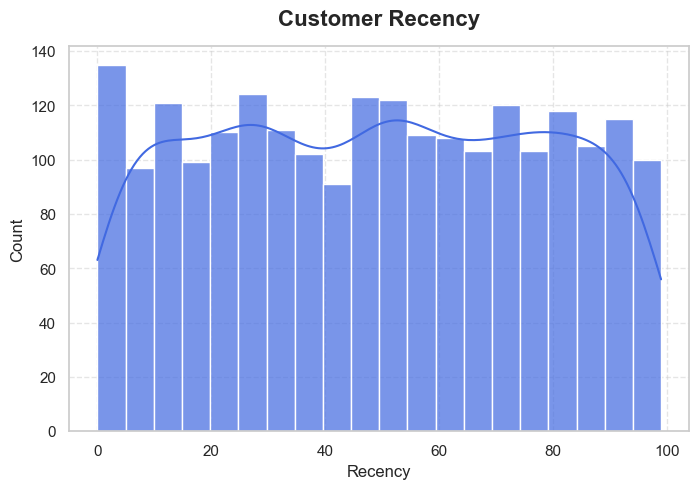

In [41]:
# sns.histplot(df, x="Recency", kde=True)
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.histplot(df, x="Recency", kde=True, color="royalblue", bins=20, alpha=0.7)

plt.title("Customer Recency", fontsize=16, fontweight="bold", pad=15)
plt.xlabel("Recency", fontsize=12)
plt.ylabel("Count", fontsize=12)

plt.grid(True, linestyle="--", alpha=0.5)

plt.show()

In [42]:
### Categorizing Recency
df['Recency_binned'] = pd.qcut(df['Recency'], q=3, labels=[1, 2, 3])

In [43]:
df.sample(10)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country,Recency_binned
1469,3643,1974,Master,Married,63206.0,0,0,2014-03-20,65,750,8,125,11,8,26,1,4,3,6,2,0,0,1,0,0,0,0,Canada,2
1473,3254,1971,Graduation,Married,70886.0,1,0,2013-10-14,65,407,70,239,103,88,53,1,5,4,4,2,0,0,0,0,0,0,0,Spain,2
340,1577,1946,Graduation,Married,78569.0,0,0,2014-02-19,14,558,79,622,207,175,95,1,4,6,4,1,0,0,1,0,0,1,0,Spain,1
1107,7214,1957,Graduation,Married,62187.0,0,0,2013-07-05,49,792,0,275,45,45,126,1,4,8,5,3,0,0,0,0,0,0,0,Spain,2
1679,6461,1969,Master,Single,62772.0,0,1,2013-05-19,74,581,49,157,43,8,108,1,5,6,11,2,0,1,0,0,0,0,0,Spain,3
1041,7453,1954,Graduation,Single,36130.0,0,1,2013-02-02,46,157,43,127,68,56,37,6,3,8,4,4,1,0,0,0,0,1,0,Spain,2
775,359,1950,Graduation,Together,48070.0,0,1,2013-01-13,33,373,14,83,6,9,19,3,8,2,6,7,0,0,0,0,0,0,1,Spain,2
451,3525,1970,Graduation,Together,38200.0,1,1,2012-12-07,19,12,0,4,0,0,1,1,1,0,2,7,0,0,0,0,0,0,0,Spain,1
2086,4094,1961,Graduation,Married,60544.0,1,1,2012-08-25,92,201,2,43,3,5,35,4,5,1,5,6,0,0,0,0,0,0,0,Australia,3
1697,5068,1971,Graduation,Single,22804.0,1,0,2013-07-31,75,14,1,7,2,1,1,1,2,0,2,9,0,0,0,0,0,0,0,Spain,3


### Evaluating Monetary

In [44]:
### Creating and Categorizing Monetary
df["Monetary"] = df["MntFishProducts"]+df["MntFruits"]+df["MntGoldProds"]+df["MntMeatProducts"]+df["MntSweetProducts"]+df["MntWines"]

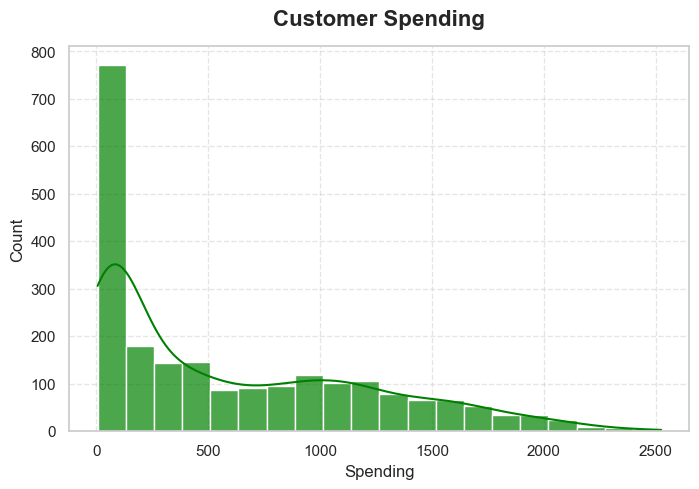

In [45]:
# sns.histplot(df, x="Monetary", kde=True)
# plt.show()

sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.histplot(df, x="Monetary", kde=True, color="green", bins=20, alpha=0.7)

plt.title("Customer Spending", fontsize=16, fontweight="bold", pad=15)
plt.xlabel("Spending", fontsize=12)
plt.ylabel("Count", fontsize=12)

plt.grid(True, linestyle="--", alpha=0.5)

plt.show()

### Evaluating Frequency

In [46]:
### Creating and Categorizing Frequency
df["Frequency_Purchase"] = df["NumWebPurchases"]+df["NumCatalogPurchases"]+df["NumDealsPurchases"]+df["NumStorePurchases"]

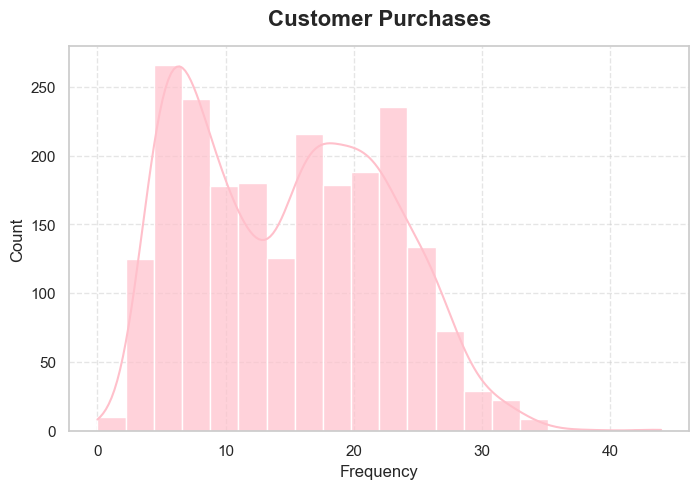

In [47]:
# sns.histplot(df, x="Frequency_Purchase", kde=True)
# plt.show()

sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.histplot(df, x="Frequency_Purchase", kde=True, color="pink", bins=20, alpha=0.7)

plt.title("Customer Purchases", fontsize=16, fontweight="bold", pad=15)
plt.xlabel("Frequency", fontsize=12)
plt.ylabel("Count", fontsize=12)

plt.grid(True, linestyle="--", alpha=0.5)

plt.show()

Because Frequency and Monetary derived from many columns, perhaps it is best to leave the column as it is and categorizing it by some clustering algorithm.

### Clustering of Frequency

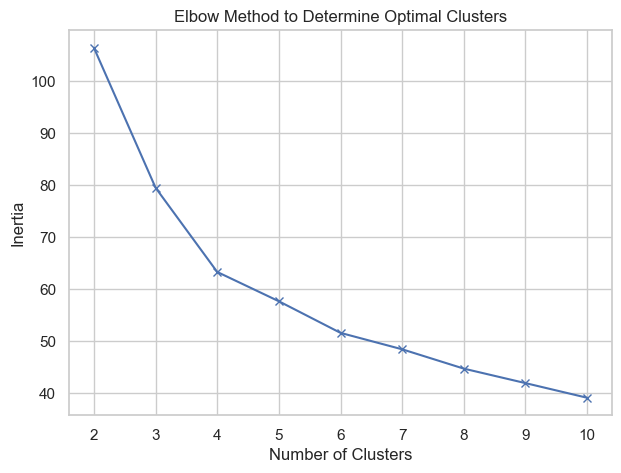

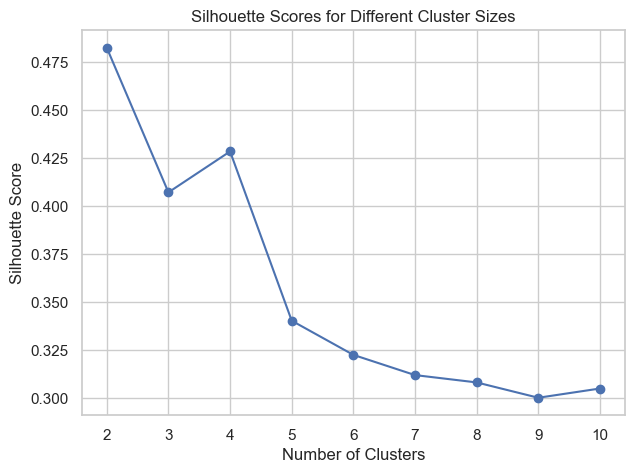

In [48]:
frequency_data = df[["NumWebPurchases","NumCatalogPurchases","NumDealsPurchases","NumStorePurchases"]]  
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(frequency_data)

# Step 2: Silhouette and Elbow plots
silhouette_scores = []
inertia = []
cluster_range = range(2, 11)  # Test for clusters from 2 to 10

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_data)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_data, labels))

# Plot Elbow Method
plt.figure(figsize=(7, 5))
plt.plot(cluster_range, inertia, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method to Determine Optimal Clusters')
plt.show()

# Plot Silhouette Scores
plt.figure(figsize=(7, 5))
plt.plot(cluster_range, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Cluster Sizes')
plt.show()

Based on the elbow plot, the optimum number of cluster is 4 clusters.

In [49]:
# Step 3: Clustering using the optimal number of clusters (choose k from the above plots)
optimal_k = 4 
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['Cluster'] = kmeans.fit_predict(scaled_data)

# Step 4: Evaluate Clustering
silhouette_avg = silhouette_score(scaled_data, df['Cluster'])
calinski_harabasz = calinski_harabasz_score(scaled_data, df['Cluster'])
davies_bouldin = davies_bouldin_score(scaled_data, df['Cluster'])

print(f"Silhouette Score: {silhouette_avg}")
print(f"Calinski-Harabasz Score: {calinski_harabasz}")
print(f"Davies-Bouldin Index: {davies_bouldin}")

Silhouette Score: 0.4284726733362278
Calinski-Harabasz Score: 1845.826404402281
Davies-Bouldin Index: 1.039569838741989


In [50]:
selected_columns = ["NumWebPurchases","NumCatalogPurchases","NumDealsPurchases","NumStorePurchases"]

# Prepare data for radar plot
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=selected_columns)

# Normalize cluster centers for radar plot
radar_data = pd.concat([cluster_centers], ignore_index = True)

In [51]:
radar_data

,NumWebPurchases,NumCatalogPurchases,NumDealsPurchases,NumStorePurchases
0,0.204926,0.153432,0.120248,0.469478
1,0.211899,0.176444,0.130496,0.841899
2,0.073455,0.018958,0.125949,0.232136
3,0.223719,0.099206,0.456229,0.472416


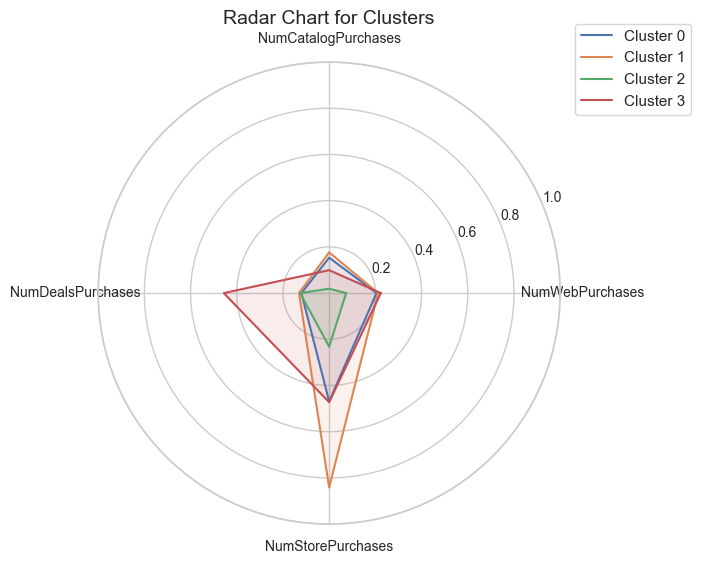

In [52]:
num_clusters = 4
categories = selected_columns
# Repeat the first value at the end to close the radar chart
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]

# Plot each cluster
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

for i in range(num_clusters):
    values = radar_data.iloc[i].tolist()
    values += values[:1]  # Repeat the first value to close the circle
    ax.plot(angles, values, label=f"Cluster {i}")
    ax.fill(angles, values, alpha=0.1)

# Add labels
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=10)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=10)

# Add legend and title
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
plt.title("Radar Chart for Clusters", fontsize=14)
plt.savefig("radar_chart.png", dpi=300, bbox_inches="tight")

# Display the chart

plt.show()

In [53]:
df["Frequency_Clustering"] = kmeans.labels_

### Clustering of Monetery

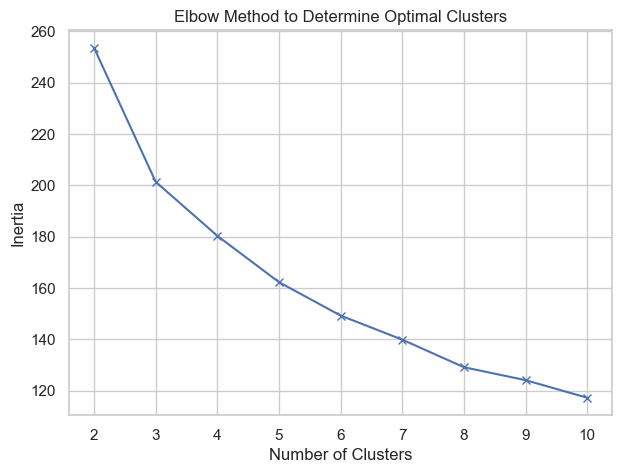

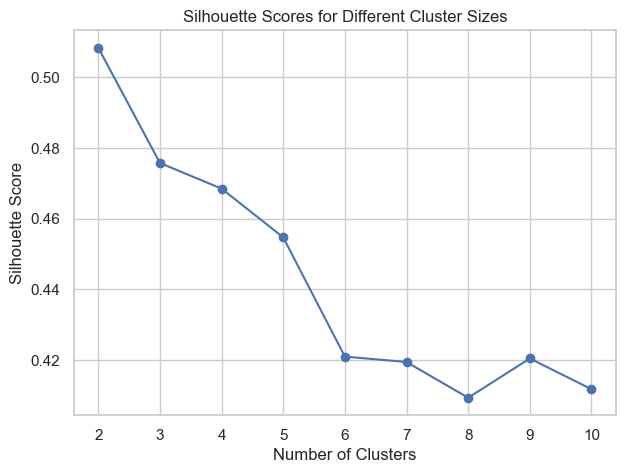

In [54]:
frequency_data = df[["MntFishProducts","MntFruits","MntGoldProds","MntMeatProducts","MntSweetProducts","MntWines"]]  
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(frequency_data)

# Step 2: Silhouette and Elbow plots
silhouette_scores = []
inertia = []
cluster_range = range(2, 11)  # Test for clusters from 2 to 10

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_data)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_data, labels))

# Plot Elbow Method
plt.figure(figsize=(7, 5))
plt.plot(cluster_range, inertia, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method to Determine Optimal Clusters')
plt.show()

# Plot Silhouette Scores
plt.figure(figsize=(7, 5))
plt.plot(cluster_range, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Cluster Sizes')
plt.show()

In [55]:
# Step 3: Clustering using the optimal number of clusters (choose k from the above plots)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['Cluster'] = kmeans.fit_predict(scaled_data)

# Step 4: Evaluate Clustering
silhouette_avg = silhouette_score(scaled_data, df['Cluster'])
calinski_harabasz = calinski_harabasz_score(scaled_data, df['Cluster'])
davies_bouldin = davies_bouldin_score(scaled_data, df['Cluster'])

print(f"Silhouette Score: {silhouette_avg}")
print(f"Calinski-Harabasz Score: {calinski_harabasz}")
print(f"Davies-Bouldin Index: {davies_bouldin}")

Silhouette Score: 0.47578862507608544
Calinski-Harabasz Score: 1367.1973871714058
Davies-Bouldin Index: 1.3617564801343087


In [56]:
selected_columns = ["MntFishProducts","MntFruits","MntGoldProds","MntMeatProducts","MntSweetProducts","MntWines"]

# Prepare data for radar plot
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=selected_columns)

# Normalize cluster centers for radar plot
radar_data = pd.concat([cluster_centers], ignore_index = True)

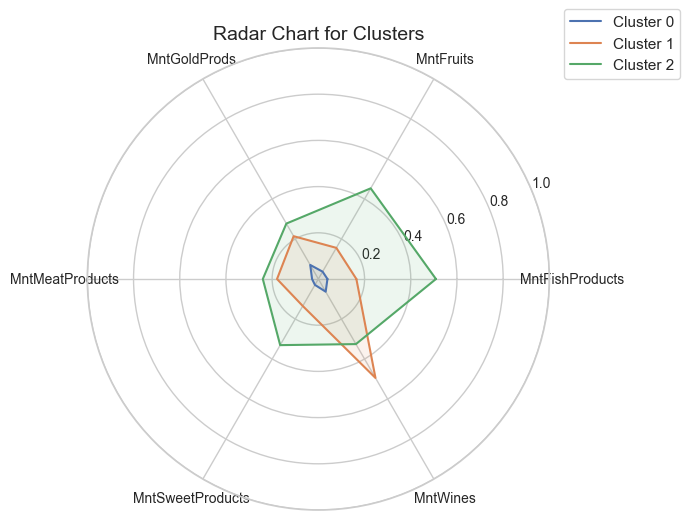

In [57]:
num_clusters = 3
categories = selected_columns
# Repeat the first value at the end to close the radar chart
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]

# Plot each cluster
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

for i in range(num_clusters):
    values = radar_data.iloc[i].tolist()
    values += values[:1]  # Repeat the first value to close the circle
    ax.plot(angles, values, label=f"Cluster {i}")
    ax.fill(angles, values, alpha=0.1)

# Add labels
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=10)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=10)

# Add legend and title
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
plt.title("Radar Chart for Clusters", fontsize=14)
plt.savefig("radar_chart.png", dpi=300, bbox_inches="tight")

# Display the chart

plt.show()

In [58]:
df["Monetary_Clustering"] = kmeans.labels_

## True RFM Analysis

In [59]:
df['RFM_Score'] = (
    df['Recency_binned'].astype(str)+
    df['Frequency_Clustering'].astype(str)+
    df['Monetary_Clustering'].astype(str)
)

In [60]:
# def assign_segment(r, f, m):
#     if r == 1 and f in [1,3] and m >= 1:
#         return 'Loyal Customers'
#     elif r == 1 and f in [1,3] and m == 0:
#         return 'Potential Loyalists'
#     elif r == 1 and f in [0,2] and m >= 0:
#         return 'Potential Loyalists'
#     elif r == 2 and f in [0,1,3] and m >= 1:
#         return 'Promising'
#     elif r == 3 and f == 2:
#         return 'Needs Attention'
#     else:
#         return 'Needs Attention'  # Mengganti 'Others' dengan 'Needs Attention'

# # Menerapkan fungsi untuk membuat kolom baru 'Segment'
# df['Segment'] = df.apply(lambda row: assign_segment(row['Recency_binned'], row['Frequency_Clustering'], row['Monetary_Clustering']), axis=1)

In [61]:
r_mapping = {
    1: "Recent Customer",
    2: "Moderately Recent",
    3: "Least Recent"
}

f_mapping = {
    2: "Least Buying",
    0: "Moderate Buyer",
    1: "Best Buyer (Web)",
    3: "Best Buyer (Deals)"
}

m_mapping = {
    0: "Low Spending",
    1: "Moderate Spending",
    2: "High Spending"
}

df['Customer_Profile'] = df.apply(
    lambda row: f"{r_mapping[row['Recency_binned']]} - {f_mapping[row['Frequency_Clustering']]} - {m_mapping[row['Monetary_Clustering']]}",
    axis=1
)

In [62]:
champions = [
    'Recent Customer - Best Buyer (Web) - Moderate Spending',
    'Recent Customer - Best Buyer (Web) - High Spending',
    'Recent Customer - Best Buyer (Deals) - Moderate Spending',
    'Recent Customer - Best Buyer (Deals) - High Spending',
    'Moderately Recent - Best Buyer (Web) - High Spending',
    'Moderately Recent - Best Buyer (Deals) - High Spending'
]

potential_loyalists = [
    'Moderately Recent - Best Buyer (Web) - Moderate Spending',
    'Moderately Recent - Best Buyer (Deals) - Moderate Spending',
    'Moderately Recent - Moderate Buyer - High Spending',
    'Moderately Recent - Moderate Buyer - Moderate Spending',
    'Recent Customer - Moderate Buyer - High Spending',
    'Recent Customer - Moderate Buyer - Moderate Spending',
    'Moderately Recent - Best Buyer (Web) - Low Spending',
    'Moderately Recent - Best Buyer (Deals) - Low Spending'
]

at_risk = [
    'Least Recent - Best Buyer (Deals) - High Spending',
    'Least Recent - Best Buyer (Deals) - Moderate Spending',
    'Least Recent - Best Buyer (Web) - High Spending',
    'Least Recent - Best Buyer (Web) - Moderate Spending',
    'Least Recent - Moderate Buyer - High Spending',
    'Least Recent - Moderate Buyer - Moderate Spending',
    'Least Recent - Least Buying - Moderate Spending'
]

low_value = [
    'Moderately Recent - Least Buying - Low Spending',
    'Moderately Recent - Least Buying - Moderate Spending',
    'Moderately Recent - Moderate Buyer - Low Spending',
    'Least Recent - Least Buying - Low Spending',
    'Least Recent - Moderate Buyer - Low Spending',
    'Least Recent - Best Buyer (Deals) - Low Spending',
    'Least Recent - Best Buyer (Web) - Low Spending',
    'Recent Customer - Least Buying - Low Spending',
    'Recent Customer - Least Buying - Moderate Spending',
    'Recent Customer - Moderate Buyer - Low Spending',
    'Recent Customer - Best Buyer (Web) - Low Spending',
    'Recent Customer - Best Buyer (Deals) - Low Spending'
]


In [63]:
def map_segmentation(rfm):
    if rfm in champions:
        return 'Champions'
    elif rfm in potential_loyalists:
        return 'Potential Loyalists'
    elif rfm in at_risk:
        return 'At Risk'
    elif rfm in low_value:
        return 'Low Value'
    else:
        return 'Unknown'

# Create a new column with the segmentation
df['Segment'] = df['Customer_Profile'].apply(map_segmentation)

### Analysis of Segments

C:\Users\Asem\AppData\Local\Temp\ipykernel_13496\2348909288.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Segment', data=df, palette='pastel', order=df['Segment'].value_counts().index)


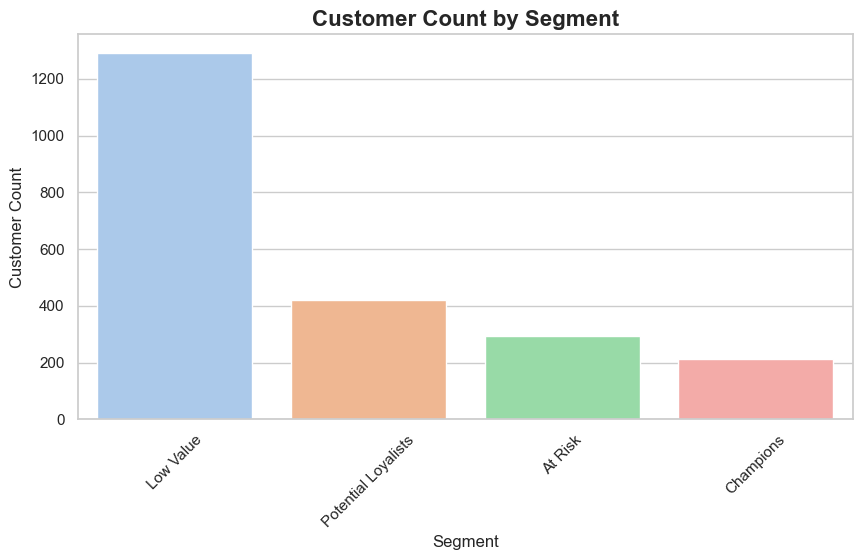

In [68]:
plt.figure(figsize=(10, 5))
sns.countplot(x='Segment', data=df, palette='pastel', order=df['Segment'].value_counts().index)
plt.title("Customer Count by Segment", fontsize=16, fontweight="bold")
plt.xlabel("Segment", fontsize=12)
plt.ylabel("Customer Count", fontsize=12)
plt.xticks(rotation=45)
plt.show()

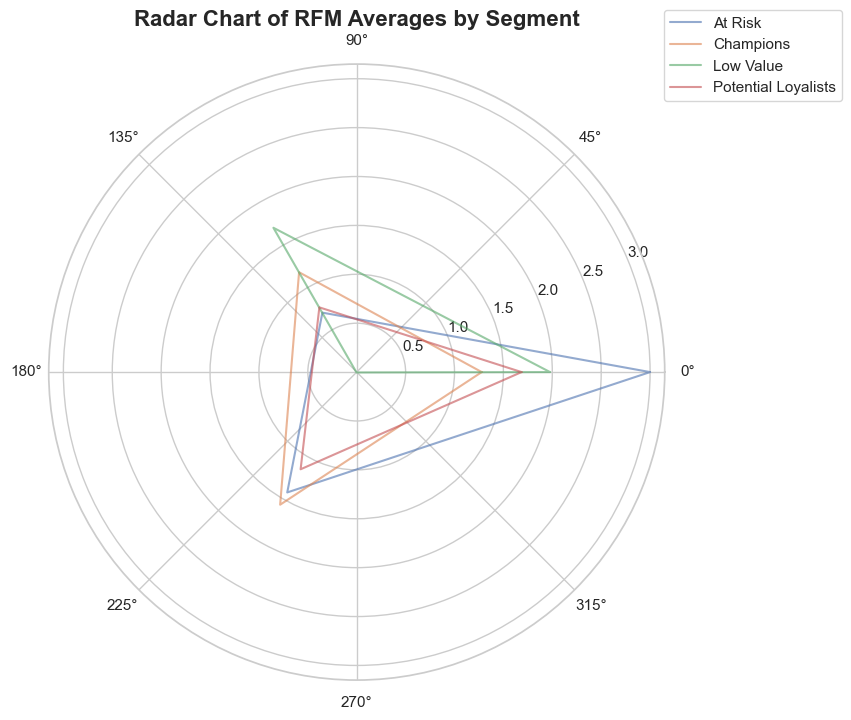

In [65]:
df['Recency_binned'] = df['Recency_binned'].astype(int)
df['Frequency_Clustering'] = df['Frequency_Clustering'].astype(int)
df['Monetary_Clustering'] = df['Monetary_Clustering'].astype(int)

rfm_avg = df.groupby('Segment')[['Recency_binned', 'Frequency_Clustering', 'Monetary_Clustering']].mean().reset_index()
categories = ['Recency', 'Frequency', 'Monetary']
num_vars = len(categories)

plt.figure(figsize=(8, 8))
for i, row in rfm_avg.iterrows():
    values = row[1:].tolist() + [row[1]]  # Repeat first value to close the radar chart
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)] + [0]
    plt.polar(angles, values, label=row['Segment'], alpha=0.6)

plt.title("Radar Chart of RFM Averages by Segment", fontsize=16, fontweight="bold")
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()

In [66]:
df.sample(10)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country,Recency_binned,Monetary,Frequency_Purchase,Cluster,Frequency_Clustering,Monetary_Clustering,RFM_Score,Customer_Profile,Segment
1283,9964,1979,Graduation,Single,61825.0,0,1,2013-08-07,56,162,50,100,55,30,27,1,4,2,8,4,0,0,0,0,0,0,0,Spain,2,424,15,0,0,0,200,Moderately Recent - Moderate Buyer - Low Spending,Low Value
1105,8143,1985,PhD,Single,37929.0,0,0,2013-07-30,49,202,2,46,3,2,10,2,4,2,5,7,0,1,0,1,0,1,0,Spain,2,265,13,0,0,0,200,Moderately Recent - Moderate Buyer - Low Spending,Low Value
1809,3945,1947,PhD,Widow,68117.0,0,1,2013-03-10,80,618,44,215,0,17,36,2,11,8,4,6,1,0,0,0,0,1,0,Spain,3,930,25,1,0,1,301,Least Recent - Moderate Buyer - Moderate Spending,At Risk
571,9291,1959,Master,Married,34242.0,0,1,2014-03-23,25,8,2,4,0,0,1,1,0,0,3,5,0,0,0,0,0,0,0,Spain,1,15,4,0,2,0,120,Recent Customer - Least Buying - Low Spending,Low Value
2022,10854,1970,PhD,Married,38853.0,1,1,2014-05-23,90,29,0,14,0,0,2,2,2,0,3,7,0,0,0,0,0,0,0,India,3,45,7,0,2,0,320,Least Recent - Least Buying - Low Spending,Low Value
1090,3571,1961,PhD,Together,63342.0,0,1,2012-10-16,48,918,21,118,13,10,21,3,8,3,5,6,0,1,0,0,0,1,0,Spain,2,1101,19,1,0,1,201,Moderately Recent - Moderate Buyer - Moderate ...,Potential Loyalists
1913,3138,1956,Graduation,Single,91249.0,0,0,2012-10-20,84,1324,27,119,71,108,27,0,7,9,6,4,0,1,1,1,1,1,0,Spain,3,1676,22,1,0,1,301,Least Recent - Moderate Buyer - Moderate Spending,At Risk
1448,773,1971,Master,Divorced,42835.0,1,1,2013-06-30,64,379,4,93,12,9,98,7,6,6,4,6,0,0,0,0,0,0,0,India,2,595,23,0,3,0,230,Moderately Recent - Best Buyer (Deals) - Low S...,Potential Loyalists
896,5835,1976,PhD,Divorced,14849.0,1,0,2013-07-02,39,21,2,28,3,2,9,3,2,0,4,8,0,0,0,0,0,0,0,Spain,2,65,9,0,2,0,220,Moderately Recent - Least Buying - Low Spending,Low Value
473,9648,1967,Graduation,Single,46904.0,1,1,2012-11-03,20,153,4,56,0,9,31,4,5,1,4,8,0,0,0,0,0,0,0,Spain,1,253,14,0,2,0,120,Recent Customer - Least Buying - Low Spending,Low Value


## Dataset to Dashboard

In [67]:
df.to_csv("marketing_data_final.csv", index = True)

## Uncleaned Codes

In [36]:
df.Country.value_counts().reset_index(), df.Country.unique()

(        Country  count
 0         Spain   1093
 1  Saudi Arabia    337
 2        Canada    266
 3     Australia    147
 4         India    147
 5       Germany    116
 6           USA    107
 7        Mexico      3,
 array(['Spain', 'Canada', 'USA', 'Australia', 'Germany', 'India',
        'Saudi Arabia', 'Mexico'], dtype=object))

In [37]:
pd.set_option('display.max_colwidth', None)
metadata

,Field,Description
0,ID,Customer's unique identifier
1,Year_Birth,Customer's birth year
2,Education,Customer's education level
3,Marital_Status,Customer's marital status
4,Income,Customer's yearly household income
5,Kidhome,Number of children in customer's household
6,Teenhome,Number of teenagers in customer's household
7,Dt_Customer,Date of customer's enrollment with the company
8,Recency,Number of days since customer's last purchase
9,MntWines,Amount spent on wine in the last 2 years


### Transition of customer behaviour for each stage of campaign

In [38]:
sankey_df = df[["AcceptedCmp1", "AcceptedCmp2", "AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5", "Response"]]

campaigns = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']
counts = {}

for i in range(len(campaigns) - 1):
    source_campaign = campaigns[i]
    target_campaign = campaigns[i + 1]

    # Count transitions from 1 to 1, 1 to 0, 0 to 1, and 0 to 0
    for source in [0, 1]:
        for target in [0, 1]:
            count = len(sankey_df[(sankey_df[source_campaign] == source) & (sankey_df[target_campaign] == target)])
            counts[(f"{source_campaign}_{source}", f"{target_campaign}_{target}")] = count

sources = []
targets = []
values = []
labels = []

# Create unique labels for each stage
label_dict = {}
index = 0
for (source, target), count in counts.items():
    if count > 0:
        if source not in label_dict:
            label_dict[source] = index
            labels.append(source)
            index += 1
        if target not in label_dict:
            label_dict[target] = index
            labels.append(target)
            index += 1
        sources.append(label_dict[source])
        targets.append(label_dict[target])
        values.append(count)

# Create the Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values
    )
))

fig.update_layout(title_text="Customer Behaviour overtime of Campaign", font_size=10)
fig.show()


In [39]:
sankey_data = pd.DataFrame({
    'Source': [labels[source] for source in sources],
    'Target': [labels[target] for target in targets],
    'Value': values
})

# Save to CSV
sankey_data.to_csv("sankey_data.csv", index=False)

### What to buy for each kidhome

In [40]:
df

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country,Recency_binned,Monetary,Frequency_Purchase,Cluster,Frequency_Clustering,Monetary_Clustering,RFM_Score,Segment,Customer_Profile
0,1826,1970,Graduation,Divorced,84835.0,0,0,2014-06-16,0,189,104,379,111,189,218,1,4,4,6,1,0,0,0,0,0,1,0,Spain,1,1190,15,2,0,2,102,Potential Loyalists,Recent Customer - Moderate Buyer - High Spending
1,1,1961,Graduation,Single,57091.0,0,0,2014-06-15,0,464,5,64,7,0,37,1,7,3,7,5,0,0,0,0,1,1,0,Canada,1,577,18,0,0,0,100,Potential Loyalists,Recent Customer - Moderate Buyer - Low Spending
2,10476,1958,Graduation,Married,67267.0,0,1,2014-05-13,0,134,11,59,15,2,30,1,3,2,5,2,0,0,0,0,0,0,0,USA,1,251,11,0,0,0,100,Potential Loyalists,Recent Customer - Moderate Buyer - Low Spending
3,1386,1967,Graduation,Together,32474.0,1,1,2014-05-11,0,10,0,1,0,0,0,1,1,0,2,7,0,0,0,0,0,0,0,Australia,1,11,4,0,2,0,120,Potential Loyalists,Recent Customer - Least Buying - Low Spending
4,5371,1989,Graduation,Single,21474.0,1,0,2014-04-08,0,6,16,24,11,0,34,2,3,1,2,7,1,0,0,0,0,1,0,Spain,1,91,8,0,2,0,120,Potential Loyalists,Recent Customer - Least Buying - Low Spending
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10142,1976,PhD,Divorced,66476.0,0,1,2013-03-07,99,372,18,126,47,48,78,2,5,2,11,4,0,0,0,0,0,0,0,USA,3,689,20,1,1,1,311,Needs Attention,Least Recent - Best Buyer (Web) - Moderate Spending
2236,5263,1977,2n Cycle,Married,31056.0,1,0,2013-01-22,99,5,10,13,3,8,16,1,1,0,3,8,0,0,0,0,0,0,0,Spain,3,55,5,0,2,0,320,Needs Attention,Least Recent - Least Buying - Low Spending
2237,22,1976,Graduation,Divorced,46310.0,1,0,2012-12-03,99,185,2,88,15,5,14,2,6,1,5,8,0,0,0,0,0,0,0,Spain,3,309,14,0,0,0,300,Needs Attention,Least Recent - Moderate Buyer - Low Spending
2238,528,1978,Graduation,Married,65819.0,0,0,2012-11-29,99,267,38,701,149,165,63,1,5,4,10,3,0,0,0,0,0,0,0,India,3,1383,20,2,1,2,312,Needs Attention,Least Recent - Best Buyer (Web) - High Spending


In [41]:
df[['Households','MntWines', 'MntFruits', 'MntMeatProducts','MntFishProducts', 'MntSweetProducts', 'MntGoldProds']].groupby(["Households"]).median().reset_index()

KeyError: "['Households'] not in index"

In [ ]:
df_grouped = df[['Kidhome','MntWines', 'MntFruits', 'MntMeatProducts','MntFishProducts', 'MntSweetProducts', 'MntGoldProds']].groupby("Kidhome").mean().reset_index()

fig = px.parallel_coordinates(df_grouped, color="Kidhome",
                              dimensions=['MntWines', 'MntFruits', 'MntMeatProducts',
                                          'MntFishProducts', 'MntSweetProducts', 'MntGoldProds'],
                              color_continuous_scale=px.colors.diverging.Tealrose,
                              color_continuous_midpoint=2)
fig.show()

### Maps for Amount of Product Categories Purchased

In [ ]:
df_group_map = df[["Country", 'MntWines', 'MntFruits', 'MntMeatProducts','MntFishProducts', 'MntSweetProducts', 'MntGoldProds']].groupby("Country").median().reset_index()

In [ ]:
columns = ['MntWines', 'MntFruits', 'MntMeatProducts','MntFishProducts', 'MntSweetProducts', 'MntGoldProds']

for column in columns:
  fig = px.scatter_geo(df_group_map, locations="Country", locationmode="country names",
                     size=column,
                     projection="natural earth",
                     title=f"Bubble Chart for Selected Countries and {column}")

  fig.show()